<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# Import some necessary modules
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import time
import scipy as sp
import pickle
%load_ext autoreload
%autoreload 2

/opt/Yonsei/python/3.8.1/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# Import MuSiCal
import musical

# Overview 

In this notebook, we demonstrate the usage of the preprocessing module, which provides two complementary methods -- cohort stratification and outlier removal. 

# Cohort stratification

We use the PCAWG ColoRect.AdenoCA dataset to demonstrate the usage of cohort stratification. We read in the mutation count matrix $X$, which contains 60 samples, and aim to investigate whether the dataset should be further stratified into subsets with distinct signature compositions. 

In [4]:
X = pd.read_csv('./data/preprocessing_example.ColoRect.AdenoCA.X.csv', index_col=0)
print(X.shape)

(96, 60)


After an initial *de novo* signature discovery with the entire dataset of 60 samples, we obtain the following signature matrix $W$ and exposure matrix $H$. 

In [5]:
W = pd.read_csv('./data/preprocessing_example.ColoRect.AdenoCA.W_denovo.csv', index_col=0)
H = pd.read_csv('./data/preprocessing_example.ColoRect.AdenoCA.H_denovo.csv', index_col=0)

Cohort stratification can be performed with the function `musical.preprocessing.stratify_samples()`. Briefly, it performs hierarchical clustering on the exposure matrix $H$ and selects the optimal number of clusters $k$ with the gap statistic. In this example, $k=3$ clusters are selected. Note that the optimal $k$ can be 1, which suggests that there is no subset structure within the dataset. 

In [12]:
k, clusters, Xs, model = musical.preprocessing.stratify_samples(X.values, H.values)
print(k)

3


We can visualize how the optimal $k$ is selected. 

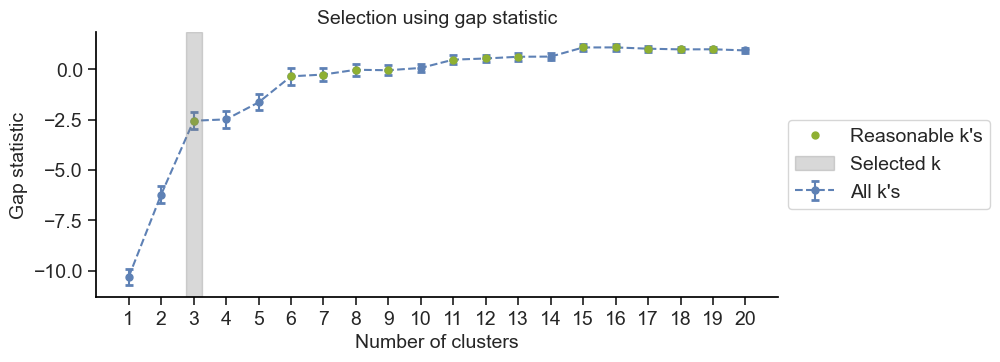

In [7]:
model.plot()

The indices of samples belonging to each cluster are stored in `clusters`. 

In [8]:
clusters

[array([52, 53, 54, 55, 56, 57, 58, 59]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 45, 46, 47, 48, 49, 50, 51])]

And the stratified mutation count matrices are stored in `Xs`. 

In [9]:
for i in range(0, k):
    print(Xs[i].shape)

(96, 8)
(96, 9)
(96, 43)


Sometimes it is helpful to check the silhouette scores of the selected clusters. Larger silhouette scores suggest clearer subset structures. 

In [10]:
model.silscorek_percluster[k]

array([0.79767023, 0.74100285, 0.59182553])

In this example, it is informative to look at the average mutational spectrum of each cluster. We can see that the first cluster corresponds to samples with POLE-exo mutations, the second cluster corresponds to MMRD samples, and the third cluster is the rest. 

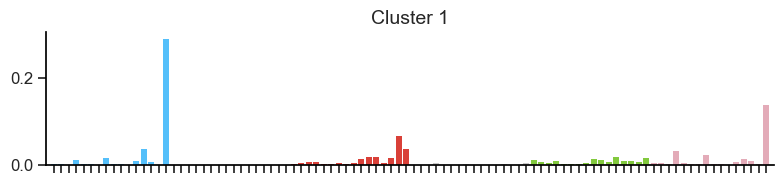

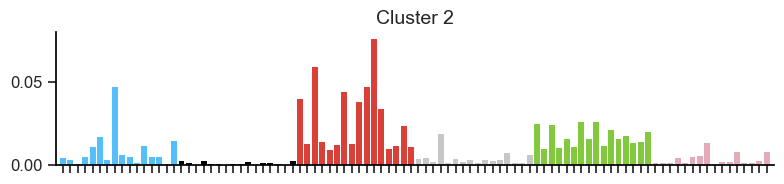

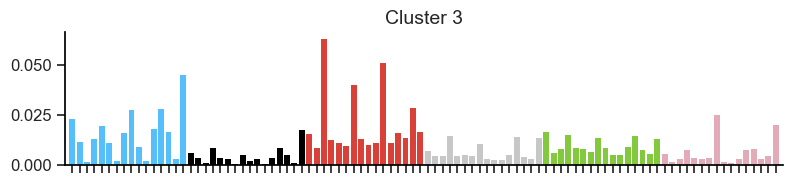

In [11]:
for i in range(0, k):
    fig = musical.sigplot_bar(np.mean(Xs[i], axis=1), title='Cluster ' + str(i + 1))

Finally, we note that the only required parameter of the function `musical.preprocessing.stratify_samples()` is $X$. When only $X$ is provided and $H$ is not, clustering will be performed on $X$ instead. Sometimes the subset structure in the dataset is strong enough such that clustering on $X$ can already be informative for the stratification. 

# Outlier removal 

We use the PCAWG CNS.GBM dataset to demonstrate the usage of outlier removal. We read in the mutation count matrix $X$, which contains 40 samples, and aim to investigate whether the dataset contains potential outliers, i.e., a small number of samples with strong exposures of signatures that are not present in other samples. 

In [13]:
X = pd.read_csv('./data/preprocessing_example.CNS.GBM.X.csv', index_col=0)
print(X.shape)

(96, 40)


After an initial *de novo* signature discovery with the entire dataset of 40 samples, we obtain the following signature matrix $W$ and exposure matrix $H$.

In [14]:
W = pd.read_csv('./data/preprocessing_example.CNS.GBM.W_denovo.csv', index_col=0)
H = pd.read_csv('./data/preprocessing_example.CNS.GBM.H_denovo.csv', index_col=0)

Outlier removal can be performed with the function `musical.preprocessing.remove_samples_based_on_gini()`. Briefly, it uses the Gini coefficient to detect signatures with nonhomogeneous exposure distributions and the corresponding outlier samples. 

In [15]:
dict_samples_to_keep, dict_X_to_keep, samples_to_keep = musical.preprocessing.remove_samples_based_on_gini(H, X)

In the output, the indices of retained non-outlier samples are stored in `samples_to_keep`. Thus the mutation count matrix after outlier removal can be obtained as follows. In this example, only 1 outlier is detected and removed. 

In [16]:
X_to_keep = pd.DataFrame.copy(X.iloc[:, samples_to_keep])
print(X_to_keep.shape)

(96, 39)


To gain further information about why the outliers are removed, we can check `dict_samples_to_keep`, which is a dictionary. The keys of the dictionary are indices of signatures deemed to have nonhomogeneous exposure distributions. The values of the dictionary are indices of non-outlier samples corresponding to the signatures. In this example, one outlier (with sample index 16) is detected because it has an exceptionally large exposure of the signature with index 0. This sample is dominated by the temozolomide signature. 

In [16]:
dict_samples_to_keep

{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39])}

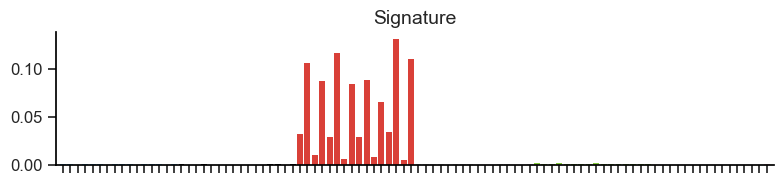

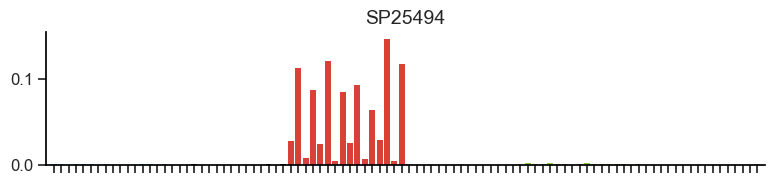

In [17]:
fig = musical.sigplot_bar(W.iloc[:, 0], title='Signature')
fig = musical.sigplot_bar(X.iloc[:, 16], title=X.columns[16])

In more detail, we see below that removing this sample results in a large reduction in the Gini coefficient for the correponding exposure distribution. 

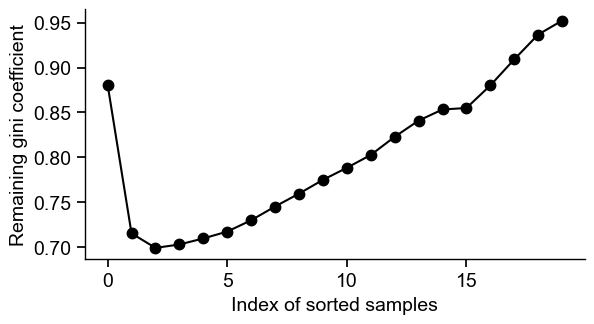

In [18]:
H_norm = np.array(H) / np.sum(np.array(X), axis=0)
sorted_h, sorted_h_indices = musical.preprocessing.sort_with_indices(H_norm[0, :])
l = [musical.preprocessing.gini(sorted_h[::-1][i:][::-1]) for i in range(0, 20)]

mpl.rcParams['pdf.fonttype'] = 42
fig = plt.figure()
sns.set_context('notebook')
sns.set_style('ticks')
plt.rc('xtick', labelsize=14, color='k')
plt.rc('ytick', labelsize=14, color='k')

subfig = fig.add_subplot(1, 1, 1)
subfig.set_title('', fontsize=14)
subfig.spines['right'].set_visible(False)
subfig.spines['top'].set_visible(False)
subfig.spines['bottom'].set_color('black')
subfig.spines['left'].set_color('black')
for axis in ['top','bottom','left','right']:
    subfig.spines[axis].set_linewidth(1)
musical.plot._set_size(5, 2.5, ax=subfig)
for tick in subfig.get_xticklabels():
    tick.set_fontname("Arial")
for tick in subfig.get_yticklabels():
    tick.set_fontname("Arial")
subfig.set_xlabel('Index of sorted samples', fontsize=14, color='k')
subfig.set_ylabel('Remaining gini coefficient', fontsize=14, color='k')

subfig.plot(l, '.-', color='k', markersize=15)